In [62]:
#!pip install pycaret;

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.classification import *

In [64]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


# Data Wrangling

In [65]:
#load data
user = pd.read_csv('takehome_users.csv', engine='python')
engagement = pd.read_csv('takehome_user_engagement.csv')

In [66]:
user.head()

object_id        creation_time  ... org_id invited_by_user_id
0          1  2014-04-22 03:53:30  ...     11            10803.0
1          2  2013-11-15 03:45:04  ...      1              316.0
2          3  2013-03-19 23:14:52  ...     94             1525.0
3          4  2013-05-21 08:09:28  ...      1             5151.0
4          5  2013-01-17 10:14:20  ...    193             5240.0

[5 rows x 10 columns]

In [67]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [68]:
user = user.rename(columns={"object_id": "user_id"})

In [69]:
engagement.head()

time_stamp  user_id  visited
0  2014-04-22 03:53:30        1        1
1  2013-11-15 03:45:04        2        1
2  2013-11-29 03:45:04        2        1
3  2013-12-09 03:45:04        2        1
4  2013-12-25 03:45:04        2        1

In [70]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [71]:
engagement.visited.unique()

array([1])

In [72]:
engagement = engagement.drop(columns='visited')

In [73]:
engagement.user_id.unique()

array([    1,     2,     3, ..., 11998, 11999, 12000])

In [74]:
user.columns

Index(['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'],
      dtype='object')

In [75]:
user.user_id.nunique()

12000

In [76]:
df = pd.merge(engagement, user, how="left", on=['user_id'])
df = df.drop(columns='last_session_creation_time')
df['time_stamp']= pd.to_datetime(df['time_stamp'])
df['creation_time']= pd.to_datetime(df['creation_time'])

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   time_stamp                  207917 non-null  datetime64[ns]
 1   user_id                     207917 non-null  int64         
 2   creation_time               207917 non-null  datetime64[ns]
 3   name                        207917 non-null  object        
 4   email                       207917 non-null  object        
 5   creation_source             207917 non-null  object        
 6   opted_in_to_mailing_list    207917 non-null  int64         
 7   enabled_for_marketing_drip  207917 non-null  int64         
 8   org_id                      207917 non-null  int64         
 9   invited_by_user_id          116887 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 17.4+ MB


In [78]:
df.head()

time_stamp  user_id  ... org_id invited_by_user_id
0 2014-04-22 03:53:30        1  ...     11            10803.0
1 2013-11-15 03:45:04        2  ...      1              316.0
2 2013-11-29 03:45:04        2  ...      1              316.0
3 2013-12-09 03:45:04        2  ...      1              316.0
4 2013-12-25 03:45:04        2  ...      1              316.0

[5 rows x 10 columns]

In [79]:
df['freq'] = df['time_stamp'].dt.floor('d').astype(np.int64)
#sorting and remove duplicated days per users 
df = df.sort_values(['user_id', 'time_stamp']).drop_duplicates()

In [80]:
a = df.groupby('user_id')['freq'].rolling(window=3)
b = pd.to_timedelta((a.max()- a.min())).dt.days

In [81]:
print(b)

user_id        
1        0          NaN
2        1          NaN
         2          NaN
         3         24.0
         4         26.0
                   ... 
11996    207912     NaN
11997    207913     NaN
11998    207914     NaN
11999    207915     NaN
12000    207916     NaN
Name: freq, Length: 207917, dtype: float64


In [82]:
c = b[b == 7].index.get_level_values('user_id').tolist()
d = np.unique(c)

In [83]:
print(d)

[    2    10    33 ... 11969 11975 11988]


In [84]:
df["adopted"] = np.where(df["user_id"].isin(d), 1, 0)
df = df.drop(columns='freq')
df.sample(10)

time_stamp  user_id  ... invited_by_user_id adopted
23691  2014-02-02 14:03:45     1421  ...             1950.0       1
164090 2013-02-18 19:46:41     9390  ...             4541.0       1
28182  2013-06-29 05:43:47     1769  ...                NaN       1
115374 2014-04-15 12:26:32     6401  ...                NaN       1
164720 2013-06-06 13:23:57     9402  ...              879.0       1
163939 2014-01-22 19:49:01     9381  ...             6171.0       1
111737 2014-04-18 09:49:10     6204  ...             6204.0       1
204116 2013-05-09 11:58:37    11730  ...             1400.0       1
116492 2014-01-22 22:09:42     6464  ...             6126.0       1
162280 2013-03-31 23:34:04     9325  ...                NaN       1

[10 rows x 11 columns]

In [85]:
user['adopted'] = np.where(user["user_id"].isin(d), 1, 0)
user.sample(5)

user_id        creation_time  ... invited_by_user_id adopted
11429    11430  2012-05-31 01:42:31  ...             5677.0       0
9763      9764  2012-07-01 09:48:15  ...             1722.0       0
2960      2961  2014-03-20 00:44:40  ...                NaN       0
7112      7113  2013-10-21 19:55:09  ...             8369.0       0
9817      9818  2014-05-12 21:39:49  ...             9899.0       0

[5 rows x 11 columns]

In [86]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted                     12000 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


In [87]:
df = user.drop(columns=['creation_time','user_id','name','email','last_session_creation_time','invited_by_user_id','org_id'])

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   creation_source             12000 non-null  object
 1   opted_in_to_mailing_list    12000 non-null  int64 
 2   enabled_for_marketing_drip  12000 non-null  int64 
 3   adopted                     12000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 375.1+ KB


# EDA

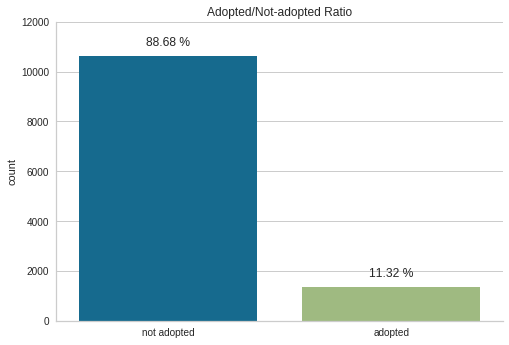

In [89]:
# Visualize adopted/not-adopted ratio
ax = sns.countplot(x=df["adopted"])
ax.set_title("Adopted/Not-adopted Ratio")

ax.set(ylim=(0, 12000))
ax.annotate(format(len(df[df.adopted==1])/len(df)*100, ".2f")+' %',(0.9,len(df[df.adopted==1])+400))
ax.annotate(format(len(df[df.adopted==0])/len(df)*100, ".2f")+' %',(-0.1,len(df[df.adopted==0])+400))
sns.despine(bottom = False, left = False)
ax.set_xticklabels(['not adopted','adopted'])
ax.set(xlabel=None)
plt.show()

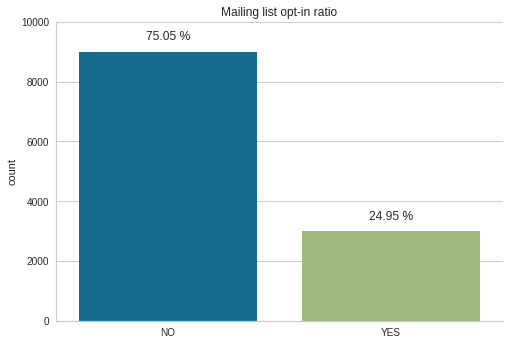

In [90]:
# Visualize mailing list ratio
ax = sns.countplot(x=df.opted_in_to_mailing_list)
ax.set_title("Mailing list opt-in ratio")

ax.set(ylim=(0, 10000))
ax.annotate(format(len(df[df.opted_in_to_mailing_list==1])/len(df)*100, ".2f")+' %',(0.9,len(df[df.opted_in_to_mailing_list==1])+400))
ax.annotate(format(len(df[df.opted_in_to_mailing_list==0])/len(df)*100, ".2f")+' %',(-0.1,len(df[df.opted_in_to_mailing_list==0])+400))
sns.despine(bottom = False, left = False)
ax.set_xticklabels(['NO','YES'])
ax.set(xlabel=None)
plt.show()

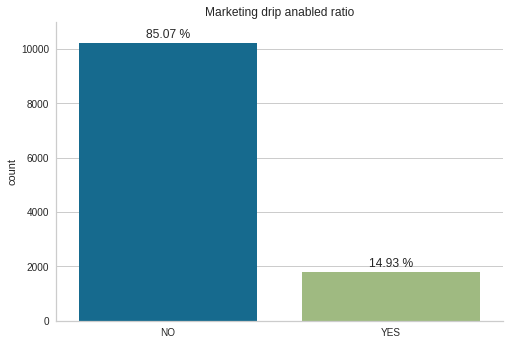

In [91]:
# Visualize marketing drip ratio
ax = sns.countplot(x=df.enabled_for_marketing_drip)
ax.set_title("Marketing drip anabled ratio")

ax.set(ylim=(0, 11000))
ax.annotate(format(len(df[df.enabled_for_marketing_drip==1])/len(df)*100, ".2f")+' %',(0.9,len(df[df.enabled_for_marketing_drip==1])+200))
ax.annotate(format(len(df[df.enabled_for_marketing_drip==0])/len(df)*100, ".2f")+' %',(-0.1,len(df[df.enabled_for_marketing_drip==0])+200))
sns.despine(bottom = False, left = False)
ax.set_xticklabels(['NO','YES'])
ax.set(xlabel=None)
plt.show()

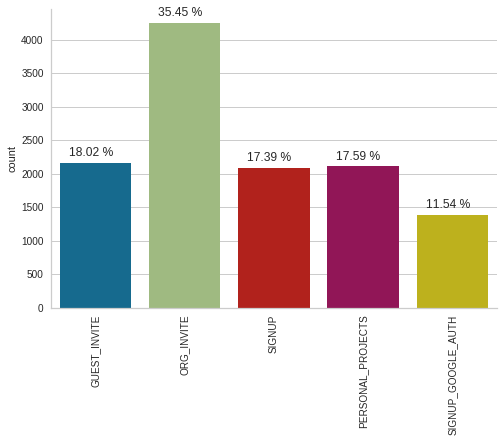

In [92]:
# Visualize creation source
ax = sns.countplot(x=df["creation_source"])

ax.annotate(format(len(df[df.creation_source=='GUEST_INVITE'])/len(df)*100, ".2f")+' %',(-0.3,len(df[df.creation_source=='GUEST_INVITE'])+100))
ax.annotate(format(len(df[df.creation_source=='ORG_INVITE'])/len(df)*100, ".2f")+' %',(0.7,len(df[df.creation_source=='ORG_INVITE'])+100))
ax.annotate(format(len(df[df.creation_source=='SIGNUP'])/len(df)*100, ".2f")+' %',(1.7,len(df[df.creation_source=='SIGNUP'])+100))
ax.annotate(format(len(df[df.creation_source=='PERSONAL_PROJECTS'])/len(df)*100, ".2f")+' %',(2.7,len(df[df.creation_source=='PERSONAL_PROJECTS'])+100))
ax.annotate(format(len(df[df.creation_source=='SIGNUP_GOOGLE_AUTH'])/len(df)*100, ".2f")+' %',(3.7,len(df[df.creation_source=='SIGNUP_GOOGLE_AUTH'])+100))

plt.xticks(rotation = 90)

sns.despine(bottom = False, left = False)
ax.set(xlabel=None)
plt.show()

# Models Building and Performance Evaluation


In [93]:
df

creation_source  ...  adopted
0            GUEST_INVITE  ...        0
1              ORG_INVITE  ...        1
2              ORG_INVITE  ...        0
3            GUEST_INVITE  ...        0
4            GUEST_INVITE  ...        0
...                   ...  ...      ...
11995          ORG_INVITE  ...        0
11996  SIGNUP_GOOGLE_AUTH  ...        0
11997        GUEST_INVITE  ...        0
11998   PERSONAL_PROJECTS  ...        0
11999              SIGNUP  ...        0

[12000 rows x 4 columns]

In [94]:
clf = setup(data = df, target = 'adopted', session_id=123, fix_imbalance=True) 

Description             Value
0                               session_id               123
1                                   Target           adopted
2                              Target Type            Binary
3                            Label Encoded              None
4                            Original Data        (12000, 4)
5                           Missing Values             False
6                         Numeric Features                 0
7                     Categorical Features                 3
8                         Ordinal Features             False
9                High Cardinality Features             False
10                 High Cardinality Method              None
11                   Transformed Train Set         (8399, 7)
12                    Transformed Test Set         (3601, 7)
13                      Shuffle Train-Test              True
14                     Stratify Train-Test             False
15                          Fold Generator   StratifiedKFold
16                             Fold Number                10
17                                CPU Jobs                -1
18                                 Use GPU             False
19                          Log Experiment             False
20                         Experiment Name  clf-default-name
21                                     USI              48df
22                         Imputation Type            simple
23          Iterative Imputation Iteration              None
24                         Numeric Imputer              mean
25      Iterative Imputation Numeric Model              None
26                     Categorical Imputer          constant
27  Iterative Imputation Categorical Model              None
28           Unknown Categoricals Handling    least_frequent
29                               Normalize             False
30                        Normalize Method              None
31                          Transformation             False
32                   Transformation Method              None
33                                     PCA             False
34                              PCA Method              None
35                          PCA Components              None
36                     Ignore Low Variance             False
37                     Combine Rare Levels             False
38                    Rare Level Threshold              None
39                         Numeric Binning             False
40                         Remove Outliers             False
41                      Outliers Threshold              None
42                Remove Multicollinearity             False
43             Multicollinearity Threshold              None
44             Remove Perfect Collinearity              True
45                              Clustering             False
46                    Clustering Iteration              None
47                     Polynomial Features             False
48                       Polynomial Degree              None
49                    Trignometry Features             False
50                    Polynomial Threshold              None
51                          Group Features             False
52                       Feature Selection             False
53                Feature Selection Method           classic
54            Features Selection Threshold              None
55                     Feature Interaction             False
56                           Feature Ratio             False
57                   Interaction Threshold              None
58                           Fix Imbalance              True
59                    Fix Imbalance Method             SMOTE

In [95]:
compare_models()

Model  Accuracy     AUC  Recall   Prec.  \
knn                K Neighbors Classifier    0.8028  0.5148  0.1328  0.1286   
dt               Decision Tree Classifier    0.5480  0.5548  0.4995  0.1200   
et                 Extra Trees Classifier    0.5480  0.5548  0.4995  0.1200   
lightgbm  Light Gradient Boosting Machine    0.5480  0.5548  0.4995  0.1200   
rf               Random Forest Classifier    0.5467  0.5543  0.5006  0.1199   
gbc          Gradient Boosting Classifier    0.5423  0.5564  0.5083  0.1199   
ada                  Ada Boost Classifier    0.5061  0.5674  0.5981  0.1259   
lr                    Logistic Regression    0.5054  0.5702  0.6003  0.1260   
ridge                    Ridge Classifier    0.5054  0.0000  0.6003  0.1260   
lda          Linear Discriminant Analysis    0.5054  0.5702  0.6003  0.1260   
nb                            Naive Bayes    0.4010  0.5698  0.7309  0.1226   
qda       Quadratic Discriminant Analysis    0.3915  0.5180  0.6802  0.1135   
svm                   SVM - Linear Kernel    0.3736  0.0000  0.7726  0.1232   

              F1   Kappa     MCC  TT (Sec)  
knn       0.1121  0.0167  0.0185     0.278  
dt        0.1931  0.0225  0.0336     0.034  
et        0.1931  0.0225  0.0336     0.629  
lightgbm  0.1931  0.0225  0.0336     0.181  
rf        0.1930  0.0222  0.0332     0.746  
gbc       0.1935  0.0224  0.0343     0.423  
ada       0.2079  0.0350  0.0580     0.287  
lr        0.2082  0.0354  0.0587     0.312  
ridge     0.2082  0.0354  0.0587     0.039  
lda       0.2082  0.0354  0.0587     0.045  
nb        0.2091  0.0294  0.0624     0.033  
qda       0.1924  0.0109  0.0254     0.036  
svm       0.2110  0.0307  0.0712     0.072

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

## SVM - Linear Kernel


In [96]:
svm = create_model('svm')

Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
0       0.2583  0.0  0.9011  0.1178  0.2084  0.0207  0.0671
1       0.3143  0.0  0.8462  0.1205  0.2110  0.0263  0.0698
2       0.2952  0.0  0.9231  0.1256  0.2211  0.0375  0.1096
3       0.4536  0.0  0.6044  0.1151  0.1933  0.0138  0.0249
4       0.5417  0.0  0.5714  0.1307  0.2127  0.0441  0.0681
5       0.5476  0.0  0.5495  0.1285  0.2083  0.0397  0.0604
6       0.2476  0.0  0.9341  0.1195  0.2120  0.0246  0.0847
7       0.5405  0.0  0.6044  0.1358  0.2218  0.0545  0.0853
8       0.2607  0.0  0.9130  0.1205  0.2129  0.0241  0.0777
9       0.2765  0.0  0.8791  0.1183  0.2086  0.0215  0.0647
Mean    0.3736  0.0  0.7726  0.1232  0.2110  0.0307  0.0712
SD      0.1240  0.0  0.1577  0.0063  0.0075  0.0120  0.0206

In [97]:
tuned_svm = tune_model(svm)

Accuracy  AUC  Recall  Prec.   F1  Kappa  MCC
0       0.8917  0.0     0.0    0.0  0.0    0.0  0.0
1       0.8917  0.0     0.0    0.0  0.0    0.0  0.0
2       0.8917  0.0     0.0    0.0  0.0    0.0  0.0
3       0.8917  0.0     0.0    0.0  0.0    0.0  0.0
4       0.8917  0.0     0.0    0.0  0.0    0.0  0.0
5       0.8917  0.0     0.0    0.0  0.0    0.0  0.0
6       0.8917  0.0     0.0    0.0  0.0    0.0  0.0
7       0.8917  0.0     0.0    0.0  0.0    0.0  0.0
8       0.8905  0.0     0.0    0.0  0.0    0.0  0.0
9       0.8915  0.0     0.0    0.0  0.0    0.0  0.0
Mean    0.8915  0.0     0.0    0.0  0.0    0.0  0.0
SD      0.0004  0.0     0.0    0.0  0.0    0.0  0.0

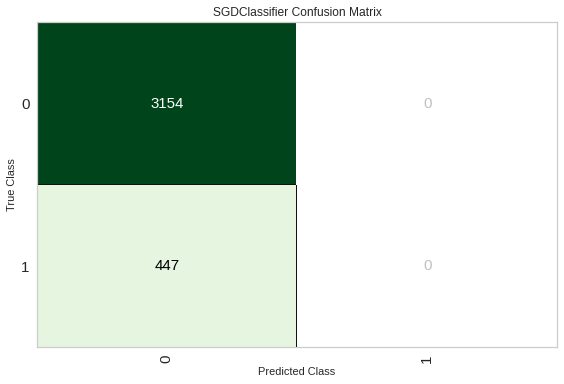

In [98]:
plot_model(tuned_svm, plot = 'confusion_matrix')

## K Neighbors classifier

In [99]:
knn = create_model('knn')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7714  0.4942  0.1648  0.1145  0.1351  0.0083  0.0085
1       0.7619  0.5455  0.1978  0.1241  0.1525  0.0224  0.0232
2       0.6202  0.5179  0.3956  0.1200  0.1841  0.0215  0.0280
3       0.7952  0.5144  0.1209  0.1068  0.1134 -0.0018 -0.0018
4       0.8548  0.4485  0.0440  0.1026  0.0615 -0.0037 -0.0041
5       0.8571  0.5035  0.0440  0.1081  0.0625 -0.0001 -0.0002
6       0.8595  0.5929  0.0989  0.2000  0.1324  0.0653  0.0702
7       0.8631  0.4955  0.0769  0.1842  0.1085  0.0478  0.0531
8       0.7702  0.4984  0.1630  0.1145  0.1345  0.0067  0.0069
9       0.8749  0.5376  0.0220  0.1111  0.0367  0.0009  0.0013
Mean    0.8028  0.5148  0.1328  0.1286  0.1121  0.0167  0.0185
SD      0.0740  0.0363  0.1038  0.0325  0.0436  0.0220  0.0241

In [100]:
tuned_knn = tune_model(knn)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7964  0.4796  0.0989  0.0918  0.0952 -0.0193 -0.0193
1       0.8917  0.5514  0.0000  0.0000  0.0000  0.0000  0.0000
2       0.8060  0.5138  0.1868  0.1604  0.1726  0.0634  0.0636
3       0.7952  0.5144  0.1209  0.1068  0.1134 -0.0018 -0.0018
4       0.8786  0.4485  0.0110  0.0769  0.0192 -0.0081 -0.0127
5       0.8571  0.5035  0.0440  0.1081  0.0625 -0.0001 -0.0002
6       0.8726  0.5858  0.0549  0.1923  0.0855  0.0392  0.0483
7       0.8810  0.5441  0.0440  0.2353  0.0741  0.0414  0.0587
8       0.7702  0.5028  0.1630  0.1145  0.1345  0.0067  0.0069
9       0.8915  0.5349  0.0000  0.0000  0.0000  0.0000  0.0000
Mean    0.8440  0.5179  0.0723  0.1086  0.0757  0.0121  0.0144
SD      0.0443  0.0367  0.0637  0.0712  0.0544  0.0251  0.0289

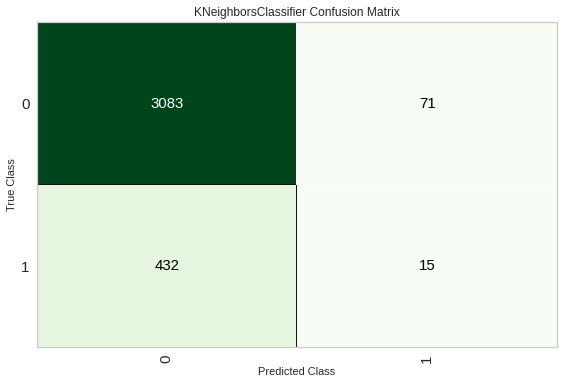

In [101]:
plot_model(tuned_knn, plot = 'confusion_matrix')

## Logistic Regression

In [102]:
lr = create_model('lr')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.5202  0.5478  0.5604  0.1232  0.2020  0.0296  0.0471
1       0.5345  0.5563  0.4945  0.1154  0.1871  0.0139  0.0211
2       0.5226  0.5949  0.6593  0.1395  0.2303  0.0627  0.1028
3       0.4833  0.5512  0.5714  0.1163  0.1933  0.0162  0.0274
4       0.5024  0.5820  0.6484  0.1326  0.2201  0.0491  0.0828
5       0.5048  0.5604  0.5495  0.1176  0.1938  0.0187  0.0303
6       0.5012  0.5652  0.6154  0.1273  0.2109  0.0383  0.0639
7       0.5405  0.6235  0.6044  0.1358  0.2218  0.0545  0.0853
8       0.4607  0.5605  0.6848  0.1294  0.2176  0.0409  0.0746
9       0.4839  0.5601  0.6154  0.1233  0.2055  0.0303  0.0520
Mean    0.5054  0.5702  0.6003  0.1260  0.2082  0.0354  0.0587
SD      0.0236  0.0223  0.0544  0.0079  0.0135  0.0158  0.0262

In [103]:
tuned_lr = tune_model(lr)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.5202  0.5478  0.5604  0.1232  0.2020  0.0296  0.0471
1       0.5345  0.5563  0.4945  0.1154  0.1871  0.0139  0.0211
2       0.5226  0.5949  0.6593  0.1395  0.2303  0.0627  0.1028
3       0.4833  0.5514  0.5714  0.1163  0.1933  0.0162  0.0274
4       0.5024  0.5808  0.6484  0.1326  0.2201  0.0491  0.0828
5       0.5048  0.5604  0.5495  0.1176  0.1938  0.0187  0.0303
6       0.5012  0.5652  0.6154  0.1273  0.2109  0.0383  0.0639
7       0.5405  0.6266  0.6044  0.1358  0.2218  0.0545  0.0853
8       0.4607  0.5605  0.6848  0.1294  0.2176  0.0409  0.0746
9       0.4839  0.5601  0.6154  0.1233  0.2055  0.0303  0.0520
Mean    0.5054  0.5704  0.6003  0.1260  0.2082  0.0354  0.0587
SD      0.0236  0.0230  0.0544  0.0079  0.0135  0.0158  0.0262

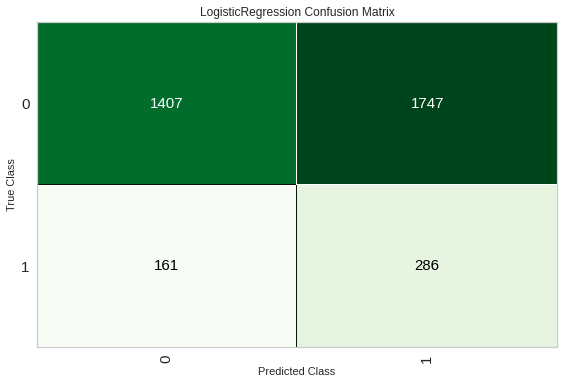

In [105]:
plot_model(tuned_lr, plot = 'confusion_matrix')